# Árboles de regresión

In [15]:
# Importamos las librerias a usar
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import FitFailedWarning

## Acerca del conjunto de datos `real_estate_data.csv`


Los datos de precios de viviendas en Boston provienen del artículo de Harrison, D. y Rubinfeld, D.L. "Precios hedónicos y la demanda de aire limpio", publicado en el Journal of Environmental Economics & Management en 1978. Estos datos también fueron utilizados en el libro "Regression diagnostics..." de Belsley, Kuh y Welsch, publicado por Wiley en 1980. Es importante tener en cuenta que en la tabla de las páginas 244-261 de este último libro se aplican diversas transformaciones a los datos.

Este conjunto de datos contiene información sobre bienes raíces en Boston y no sobre casas individuales. Las características incluyen:

- CRIM: Tasa de criminalidad per cápita
- ZN: Proporción de terreno residencial zonificado para lotes de más de 25,000 pies cuadrados.
- INDUS: Proporción de acres de negocios no minoristas por ciudad
- CHAS: Variable ficticia de Charles River (= 1 si el tramo limita con el río; 0 en caso contrario)
- NOX: Concentración de óxidos nítricos (partes por 10 millones)
- RM: Número medio de habitaciones por vivienda
- AGE: Proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- DIS: Distancias ponderadas a cinco centros de empleo de Boston
- RAD: Índice de accesibilidad a carreteras radiales
- TAX: Tasa de impuesto a la propiedad de valor total por $10,000
- PTRAIO: Ratio alumnos-profesor por localidad
- LSTAT: Porcentaje de estatus inferior de la población
- MEDV: Valor medio de viviendas ocupadas por sus propietarios en miles de dólares
[Dataset source](http://lib.stat.cmu.edu/datasets/boston)

In [16]:
 # Se importa el archivo
df = pd.read_csv("boston_housing.csv")
# visualizamos el df
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,NaN,36.2


Realizamos un analisis exploratorio

In [17]:
# Verificamos el tipo de dato en las columnas 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    486 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB


Se identifica que no todas las columnas tiene la misma cantidad de datos

In [18]:
# Contamos los valores duplicados
print(f'Verifica duplicados: ',df.duplicated().value_counts())
# Contamos los valores nulos
print(f'Verificar datos nulos:\n',df.isnull().sum())

Verifica duplicados:  False    506
dtype: int64
Verificar datos nulos:
 CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
LSTAT      20
MEDV        0
dtype: int64


No tenemos datos duplicados pero si datos faltantaes 

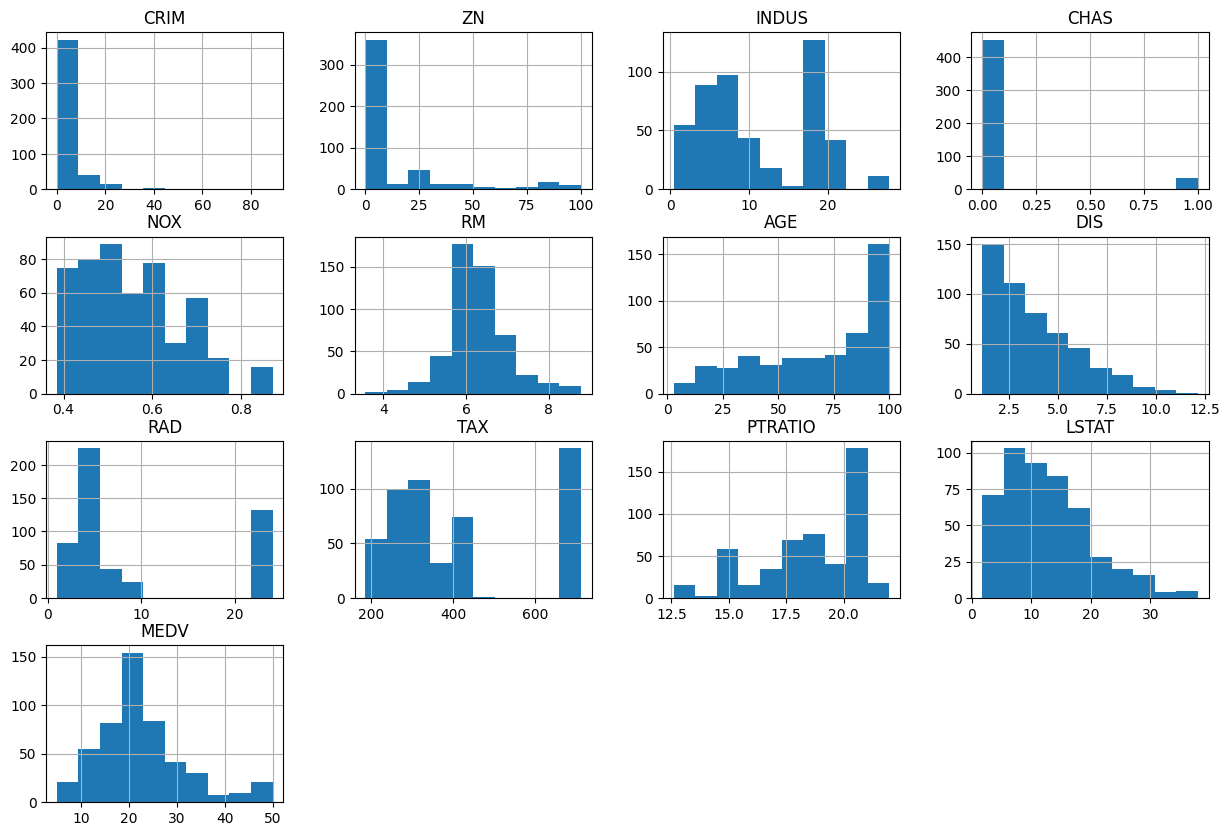

In [19]:
# Generar un histograma para cada columna
df.hist(figsize=(15, 10))  
plt.show()


Dado el sesgo observado en la distribución de los datos, realizaremos una evaluación para determinar si debemos reemplazar los valores faltantes por la media o la mediana. Dado que contamos con un número limitado de datos, la eliminación de información podría afectar el rendimiento del modelo.

In [20]:
# Verificar la distribución de cada columna con datos faltantes
for column in df.columns:
    if df[column].isnull().sum() > 0:  
        if df[column].skew() > 1.0 or  df[column].skew() < -1.0: # Verificar si la columna tiene sesgo (skewness) 
            df[column].fillna(df[column].median(), inplace=True)  # Rellenar con la mediana
        else:
            df[column].fillna(df[column].mean(), inplace=True)  # Rellenar con la media

In [21]:
# Estadisticas por columna
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.479140,10.768775,11.083992,0.067194,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,12.715432,22.532806
std,8.570832,23.025124,6.699165,0.250605,0.115878,0.702617,27.439466,2.105710,8.707259,168.537116,2.164946,7.012739,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.083235,0.000000,5.190000,0.000000,0.449000,5.885500,45.925000,2.100175,4.000000,279.000000,17.400000,7.230000,17.025000
50%,0.253715,0.000000,9.900000,0.000000,0.538000,6.208500,74.450000,3.207450,5.000000,330.000000,19.050000,11.995000,21.200000
75%,2.808720,0.000000,18.100000,0.000000,0.624000,6.623500,93.575000,5.188425,24.000000,666.000000,20.200000,16.570000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Se evidencia que no hay valores nulos y las estadisticas por columnas


## Modelo

Se definen las variables independientes y la varibale dependiente

In [22]:
# Variables predictoras
X = df.drop(columns=['MEDV']).values
# Variable objetivo
y = df['MEDV'].values

Se dividen los datos de entrenamiento y prueba

In [23]:
# Divide los datos entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Creamos el modelo

Utilizamos Grid Search para encontrar los hiperparámetros óptimos de nuestro modelo

In [33]:
# Ignorar las advertencias de ajuste fallido durante la búsqueda de hiperparámetros
warnings.filterwarnings("ignore", category=FitFailedWarning)
# Definir el modelo de árbol de regresión
model = DecisionTreeRegressor()

# Definir los hiperparámetros a buscar
param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
# Mostrar los mejores hiperparámetros encontrados

print("Mejores hiperparámetros:", grid_search.best_params_)



Mejores hiperparámetros: {'criterion': 'poisson', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


c:\Users\Willc\OneDrive\Escritorio\William\PI2_siniestros_viales\pi2-env\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan -25.45439879 -25.45439879 -25.45439879 -25.48038139
 -25.48038139 -25.48038139 -23.56408068 -23.56408068 -23.56408068
 -19.42743946 -19.94954027 -19.95113476 -18.05251804 -19.16230284
 -18.85003366 -15.94260519 -17.40010756 -15.97357003 -19.22531973
 -20.06585612 -20.07064837 -18.99367607 -19.58007486 -19.28184201
 -16.43385164 -16

In [34]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el  modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print('r2: ', r2_score(y_test, y_pred))
print('MSE: ',mean_squared_error(y_test, y_pred))

r2:  0.8729809381994083
MSE:  12.552962290120952


Un coeficiente de determinación (R^2) de 0.87 indica que el modelo explica aproximadamente el 83% de la varianza en los datos de prueba, lo cual es bastante bueno. Además, un error cuadrático medio (MSE) de 12.30 indica que, en promedio, las predicciones del modelo están a aproximadamente 12.55 unidades de los valores reales.